## Investigate the synthetic data generate from gaussian_and_multinomial diffusion

We load the original Adult data as well, such that we can compare to the "ground truth".

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics # plot_roc_curve.

from Data import Data, CustomDataset, ToTensor

plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (10, 10)


# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 25

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
device = torch.device('cpu') # We don't need GPU in this case (not computationally heavy).
print(f"Using '{device}' device.")

# Set seeds for reproducibility. 
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

categorical_features = ["workclass","marital_status","occupation","relationship", \
                        "race","sex","native_country"]
numerical_features = ["age","fnlwgt","education_num","capital_gain","capital_loss","hours_per_week"]

# Load the real data into the scope. 
adult_data = pd.read_csv("adult_data_no_NA.csv", index_col = 0)
print(adult_data.shape)

Adult = Data(adult_data, categorical_features, numerical_features, scale_version = "quantile", splits = [0.85,0.15])
X_train, y_train = Adult.get_training_data()
X_test, y_test = Adult.get_test_data()
print(X_train.shape)

# Load the synthetic data into the scope. 
synthetic_samples = pd.read_csv("synthetic_sample_both.csv", index_col = 0)
print(synthetic_samples.shape)

# Make sure the data types of the two data sets are the same (just in case)
synthetic_samples[numerical_features] = synthetic_samples[numerical_features].astype("int64")

Using 'cpu' device.
(45222, 14)
Feature 'workclass'' has 7 unique levels
Feature 'marital_status'' has 7 unique levels
Feature 'occupation'' has 14 unique levels
Feature 'relationship'' has 6 unique levels
Feature 'race'' has 5 unique levels
Feature 'sex'' has 2 unique levels
Feature 'native_country'' has 41 unique levels
The sum of all levels is 82. This will be the number of cat-columns after one-hot encoding (non-full rank)
(38438, 13)
(38438, 13)


In [3]:
def plot_categorical_features(synthetic_data, real_data, categorical_features):
    """Plot the categorical features are barplots."""
    fig, axs = plt.subplots(2,2)
    axs = axs.ravel()
    for idx, ax in enumerate(axs):
        (synthetic_data[categorical_features[idx]].value_counts()/synthetic_data.shape[0]*100).plot(kind='bar', ax = ax, label = "Synth.")
        (real_data[categorical_features[idx]].value_counts()/real_data.shape[0]*100).plot(kind='bar', ax = ax, color = "orange", alpha = 0.7, label = "OG.")
        ax.xaxis.set_ticklabels([])
        ax.legend()
        ax.title.set_text(f"% {categorical_features[idx]}")
        
    plt.tight_layout()

    # Make two grids since 7 is not an even number of categorical features. 
    fig, axs2 = plt.subplots(2,2)
    axs2 = axs2.ravel()
    for idx, ax in enumerate(axs2, start = 4):
        if idx > len(categorical_features)-1:
            break
        (synthetic_data[categorical_features[idx]].value_counts()/synthetic_data.shape[0]*100).plot(kind='bar', ax = ax, label = "Synth.")
        (real_data[categorical_features[idx]].value_counts()/real_data.shape[0]*100).plot(kind='bar', ax = ax, color = "orange", alpha = 0.6, label = "OG.")
        ax.xaxis.set_ticklabels([])
        ax.legend()
        ax.title.set_text(f"% {categorical_features[idx]}")
    plt.tight_layout()

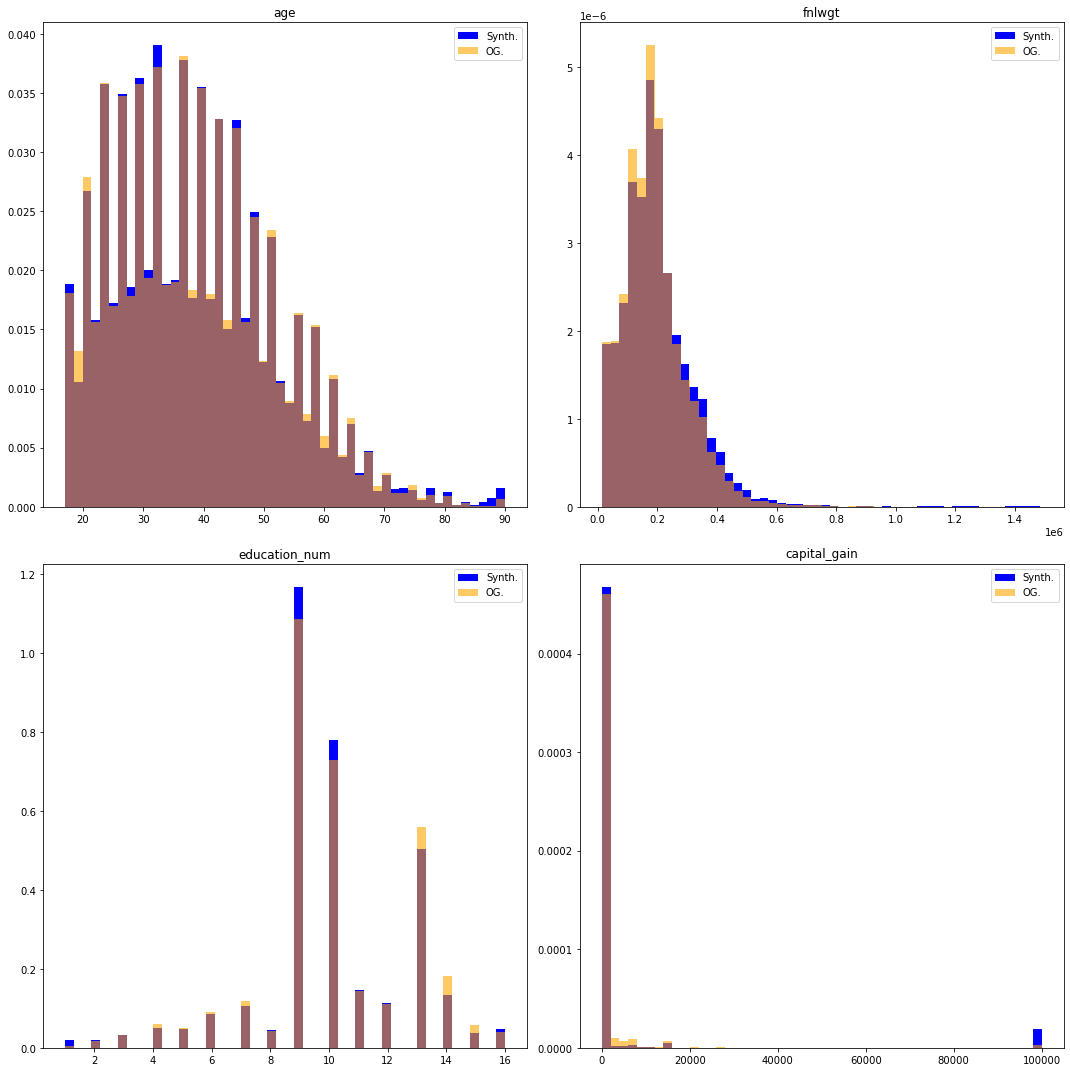

In [4]:
fig, axs = plt.subplots(2,2, figsize = (15,15))
axs = axs.ravel()
for idx, ax in enumerate(axs):
    ax.hist(synthetic_samples[numerical_features[idx]], density = True, color = "b", label = "Synth.", bins = 50)
    ax.hist(X_train[numerical_features[idx]], color = "orange", alpha = 0.6, density = True, label = "OG.", bins = 50)
    ax.legend()
    ax.title.set_text(numerical_features[idx])
plt.tight_layout()

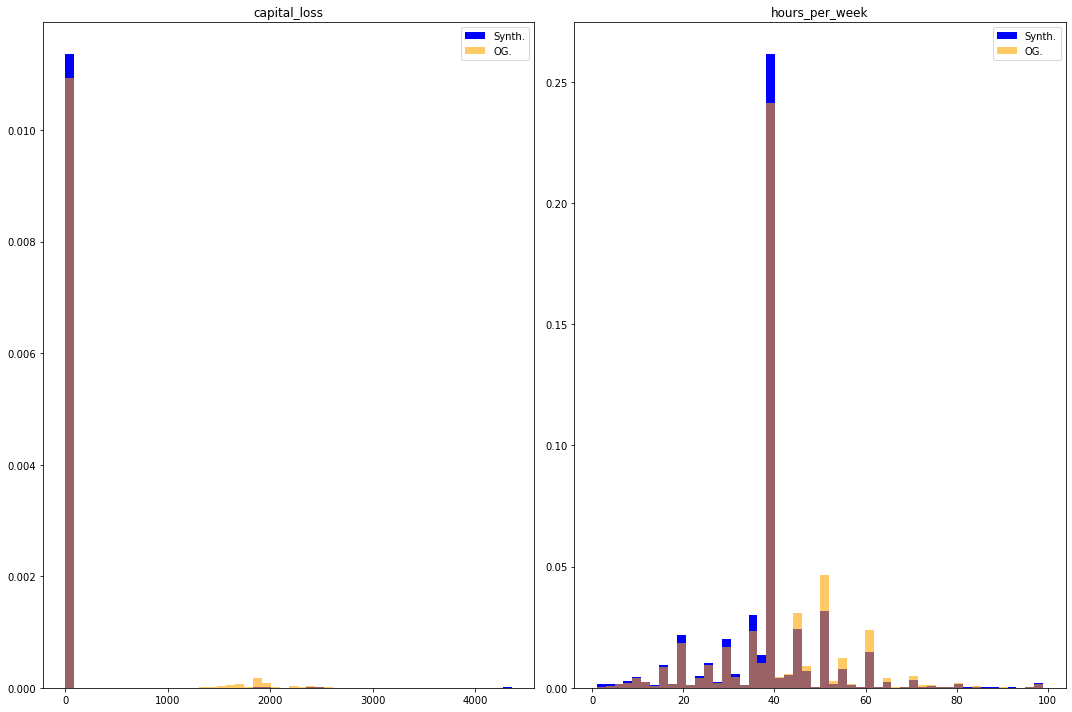

In [5]:
fig, axs = plt.subplots(1,2, figsize = (15,10))
axs = axs.ravel()
for idx, ax in enumerate(axs, start = 4):
    ax.hist(synthetic_samples[numerical_features[idx]], density = True, color = "b", label = "Synth.", bins = 50)
    ax.hist(X_train[numerical_features[idx]], color = "orange", alpha = 0.6, density = True, label = "OG.", bins = 50)
    ax.legend()
    ax.title.set_text(numerical_features[idx])
plt.tight_layout()

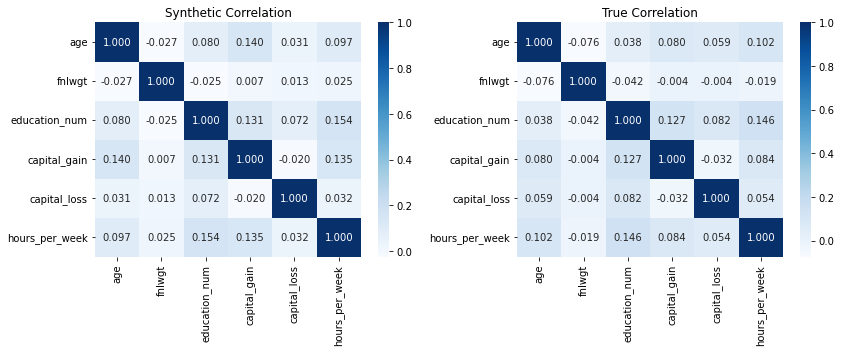

In [30]:
synthetic_corr = synthetic_samples.corr()
true_corr = adult_data.iloc[:,:-1].corr()

fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(synthetic_corr, annot = True, fmt = ".3f", ax = ax[0], cmap = "Blues")
ax[0].set_title("Synthetic Correlation")
sns.heatmap(true_corr, annot = True, fmt = ".3f", ax = ax[1], cmap = "Blues")
ax[1].set_title("True Correlation")
plt.tight_layout()

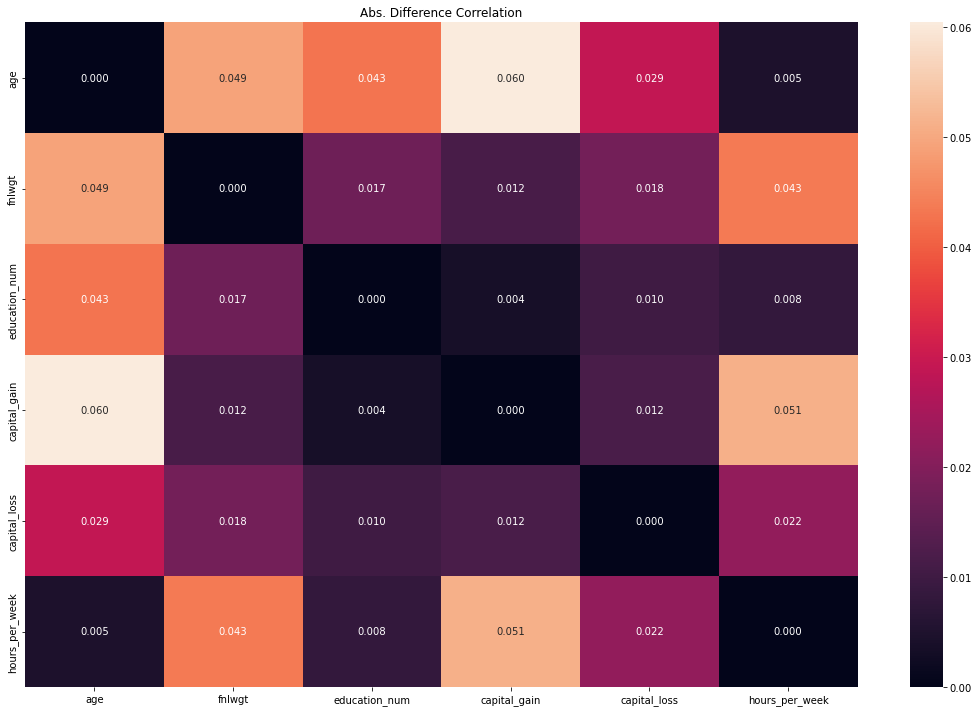

In [7]:
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(np.abs(true_corr - synthetic_corr), annot = True, fmt = ".3f", ax = ax)
ax.set_title("Abs. Difference Correlation")
plt.tight_layout()

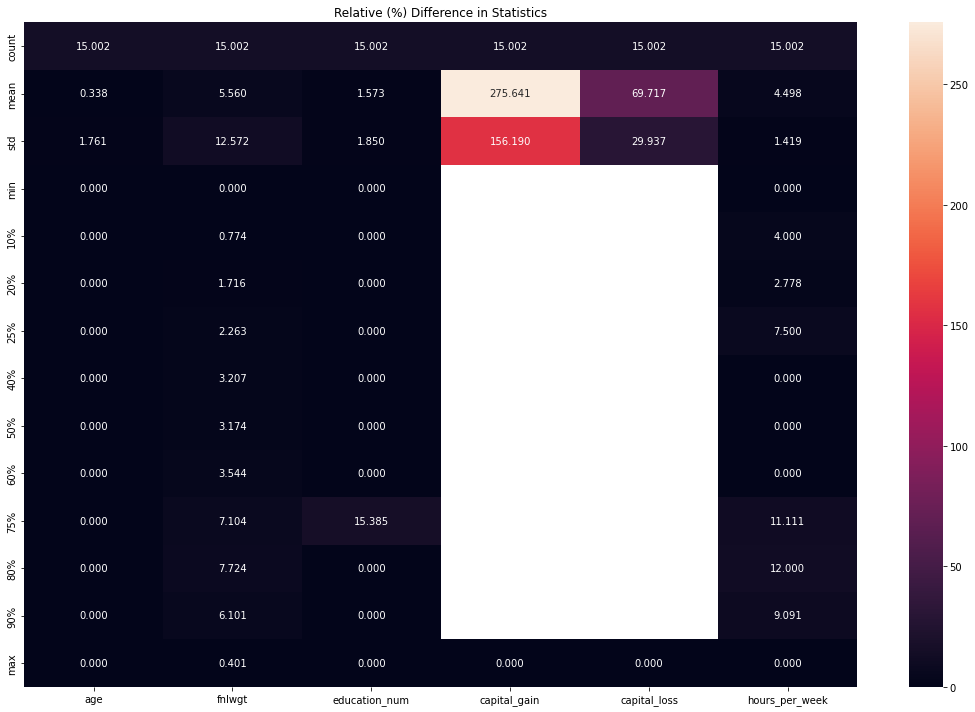

In [35]:
percentiles = [0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9]
desc_synth = synthetic_samples.describe(percentiles = percentiles)
desc_true = adult_data.iloc[:,:-1].describe(percentiles = percentiles)

fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(np.divide(np.abs(desc_synth - desc_true),desc_true)*100, annot = True, fmt = ".3f", ax = ax)
ax.set_title("Relative (%) Difference in Statistics")
plt.tight_layout()

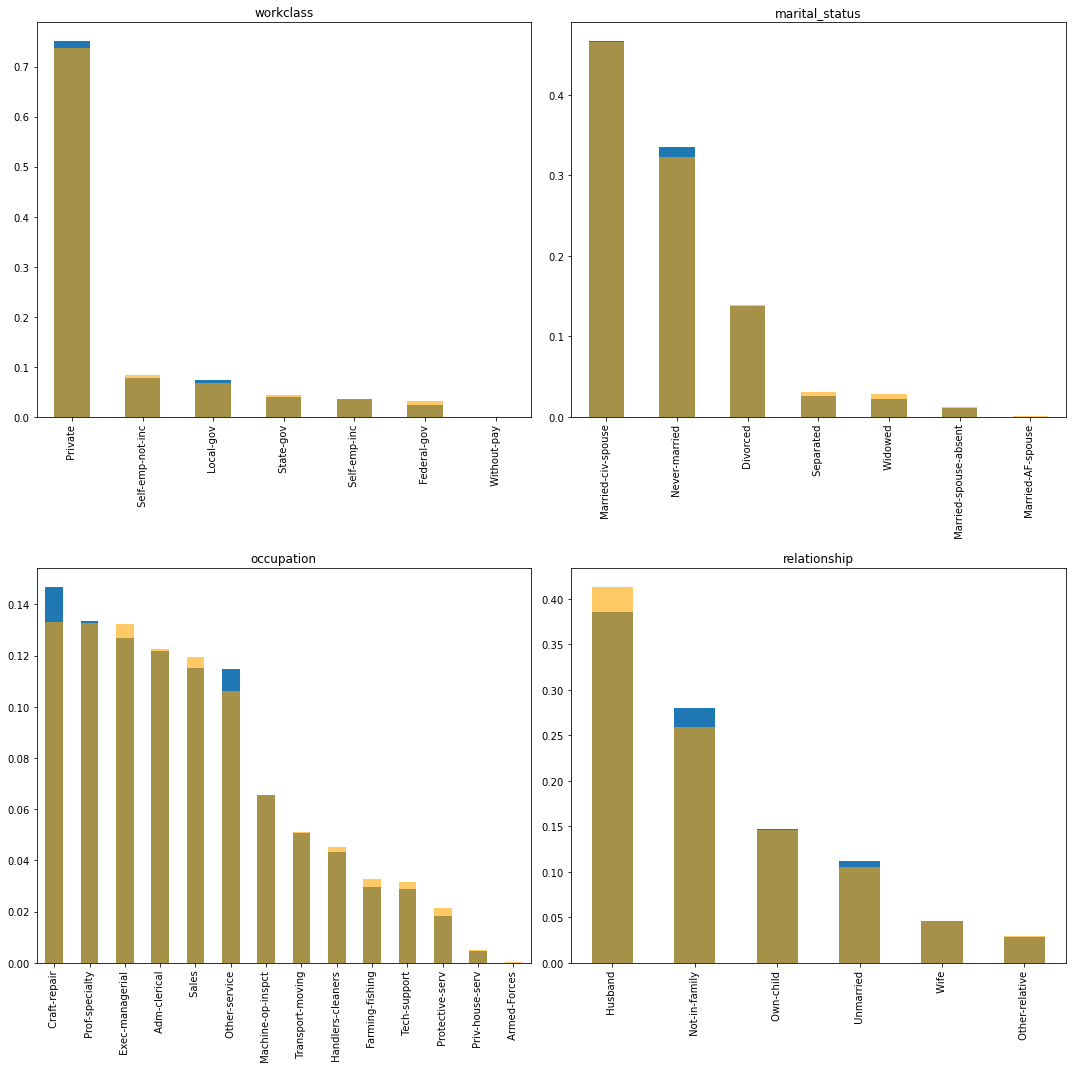

In [9]:
fig, axs = plt.subplots(2,2, figsize = (15, 15))
axs = axs.ravel()
for idx, ax in enumerate(axs):
    (synthetic_samples[categorical_features[idx]].value_counts()/synthetic_samples.shape[0]).plot(kind='bar', ax = ax)
    (adult_data[categorical_features[idx]].value_counts()/adult_data.shape[0]).plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
plt.tight_layout()

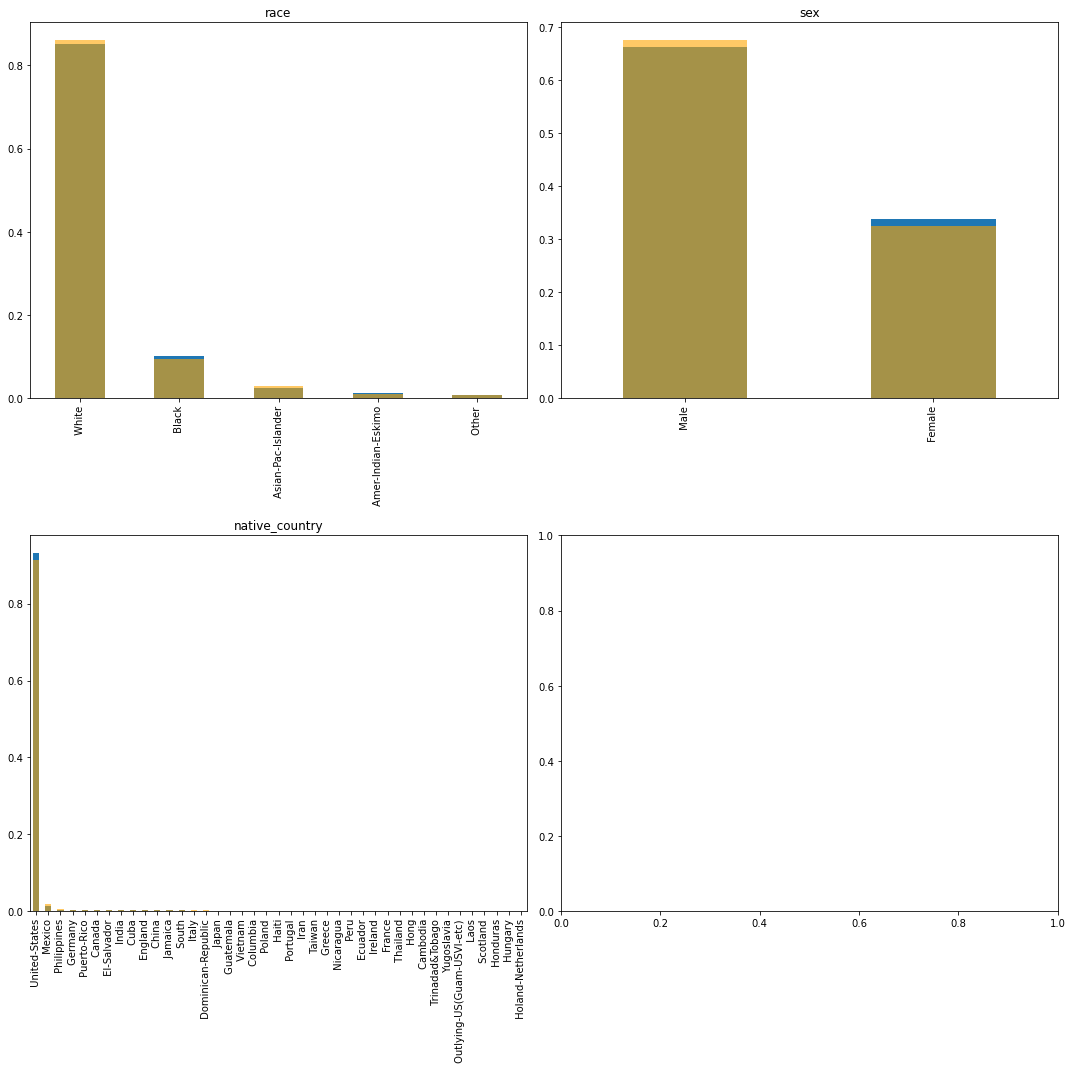

In [10]:
fig, axs = plt.subplots(2,2, figsize = (15, 15))
axs = axs.ravel()
for idx, ax in enumerate(axs, start = 4):
    if idx > len(categorical_features)-1:
        break
    (synthetic_samples[categorical_features[idx]].value_counts()/synthetic_samples.shape[0]).plot(kind='bar', ax = ax)
    (adult_data[categorical_features[idx]].value_counts()/adult_data.shape[0]).plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
plt.tight_layout()

In [55]:
# Calculate correlations between categorical variables
# using Theil's U statistic.
# https://en.wikipedia.org/wiki/Uncertainty_coefficient
from dython.nominal import associations

synth2 = synthetic_samples.copy()
adult2 = adult_data.iloc[:,:-1].copy()

adult2 = adult2[synth2.columns.tolist()]

synthetic_corr = associations(synth2, nominal_columns=categorical_features, 
            numerical_columns=numerical_features, nom_nom_assoc='theil',
            num_num_assoc='pearson', compute_only = True)["corr"]

true_corr = associations(adult2, nominal_columns=categorical_features, 
            numerical_columns=numerical_features, nom_nom_assoc='theil',
            num_num_assoc='pearson', compute_only = True)["corr"]

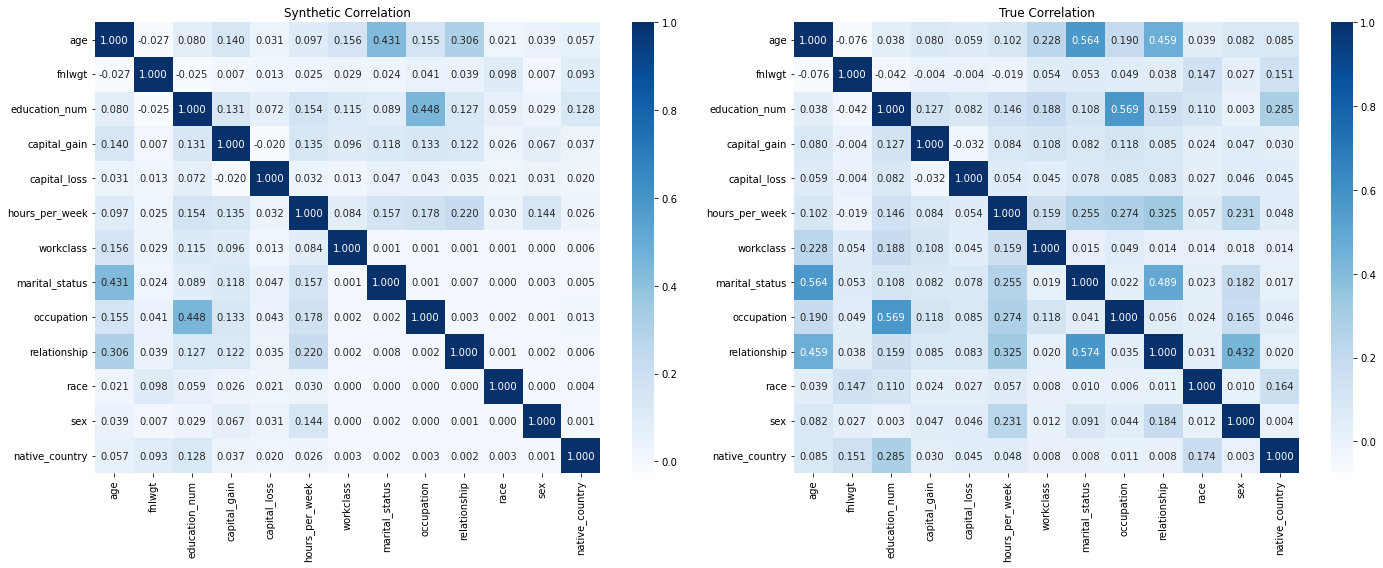

In [57]:
# plot:
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(synthetic_corr, annot = True, fmt = ".3f", ax = ax[0], cmap = "Blues")
ax[0].set_title("Synthetic Correlation")
sns.heatmap(true_corr, annot = True, fmt = ".3f", ax = ax[1], cmap = "Blues")
ax[1].set_title("True Correlation")
plt.tight_layout()

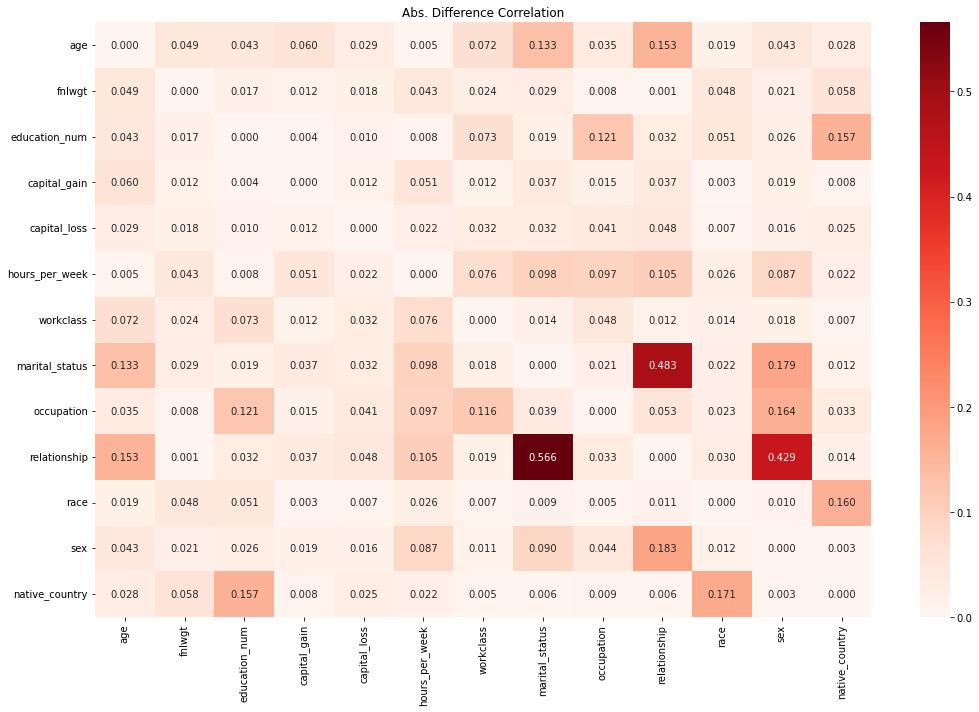

In [59]:
# Plot absolute difference between them.
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(np.abs(true_corr - synthetic_corr), annot = True, fmt = ".3f", ax = ax, cmap = "Reds")
ax.set_title("Abs. Difference Correlation")
plt.tight_layout()

In [31]:
# Calculate correlations between categorical and numerical variables,
# using the correlation Ratio.

In [42]:
# Good source:
# https://medium.com/the-researchers-guide/generate-numerical-correlation-and-nominal-association-plots-using-python-c8548aa4a663

In [43]:
# All the three are done automatically above!